In [11]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="./")

> 2022-06-19 14:38:11,494 [info] loaded project stocks from MLRun DB


In [12]:
# from mlrun.runtimes import Spark3Runtime
# Spark3Runtime.deploy_default_image()

In [13]:
# mlrun: start-code
from mlrun.feature_store.api import ingest
from IPython.display import display


def ingest_handler(context):
    ingest(mlrun_context=context) # The handler function must call ingest with the mlrun_context

# You can add your own PySpark code as a graph step:
def filter_func(df, context=None):
    return df.filter("bid>55") # PySpark code


def add_column(df, context=None):
    return_df = df.withColumn("bid_ask_diff", df.bid-df.ask)
    return return_df

def print_dataframe(df, contest=None):
    print("type of data frame {}".format(type(df)))        
    print(df.show())
    return df

# mlrun: end-code

In [14]:
from mlrun.datastore.sources import CSVSource
from mlrun import code_to_function
import mlrun.feature_store as fstore

feature_set = fstore.FeatureSet("stocks", entities=[fstore.Entity("ticker")],timestamp_key='Datetime', engine="spark")

#source = CSVSource("mycsv", path="v3io:///users/aviaIguazio/demos/stock-analysis/data/input.csv")
source = CSVSource("mycsv", path="v3io:///projects/input.csv")

feature_set.graph\
    .to(name="print_dataframe", handler="print_dataframe")


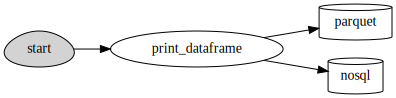

In [15]:
    
# Setting default targets (nosql & parquet)
feature_set.set_targets(with_defaults=True) 
feature_set.plot(rankdir="LR", with_targets=True)

In [16]:
my_func = code_to_function("func", kind="spark")

my_func.with_driver_requests(cpu=1, mem="1G")
my_func.with_executor_requests(cpu=1, mem="1G")
my_func.with_igz_spark()

# Enables using the default image (can be replace with specifying a specific image with .spec.image)
my_func.spec.use_default_image = True

# Not a must - default: 1
my_func.spec.replicas = 2

# If needed, sparkConf can be modified like this:
# my_func.spec.spark_conf['spark.specific.config.key'] = 'value'

config = fstore.RunConfig(local=False, function=my_func, handler="ingest_handler")
quotes_df = fstore.ingest(feature_set, source, run_config=config)

> 2022-06-19 14:38:23,867 [info] starting run stocks-ingest uid=0ad6d9e0a5034930a12ab6b267d84db0 DB=http://mlrun-api:8080
++ id -u
+ myuid=1000
++ id -g
+ mygid=1000
+ set +e
++ getent passwd 1000
+ uidentry=iguazio:x:1000:1000::/igz:/bin/bash
+ set -e
+ '[' -z iguazio:x:1000:1000::/igz:/bin/bash ']'
+ SPARK_CLASSPATH=':/spark/jars/*'
+ env
+ grep SPARK_JAVA_OPT_
+ sort -t_ -k4 -n
+ sed 's/[^=]*=\(.*\)/\1/g'
+ readarray -t SPARK_EXECUTOR_JAVA_OPTS
+ '[' -n '' ']'
+ '[' -z ']'
+ '[' -z ']'
+ '[' -n /hadoop ']'
+ '[' -z '' ']'
++ /hadoop/bin/hadoop classpath
+ export 'SPARK_DIST_CLASSPATH=/hadoop/etc/hadoop:/hadoop/share/hadoop/common/lib/*:/hadoop/share/hadoop/common/*:/hadoop/share/hadoop/hdfs:/hadoop/share/hadoop/hdfs/lib/*:/hadoop/share/hadoop/hdfs/*:/hadoop/share/hadoop/mapreduce/lib/*:/hadoop/share/hadoop/mapreduce/*:/hadoop/share/hadoop/yarn:/hadoop/share/hadoop/yarn/lib/*:/hadoop/share/hadoop/yarn/*:/hadoop/share/hadoop/tools/lib/hadoop-aws-3.2.0.jar:/hadoop/share/hadoop/tools/li

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
stocks-avia,...67d84db0,0,Jun 19 14:38:39,completed,stocks-ingest,job-type=feature-ingestfeature-set=store://feature-sets/stocks-avia/stocksv3io_user=aviakind=sparkowner=aviamlrun/client_version=1.0.4mlrun/job=stocks-ingest-56d51693host=stocks-ingest-56d51693-driver,,"infer_options=63overwrite=Nonefeatureset=store://feature-sets/stocks-avia/stockssource={'kind': 'csv', 'name': 'mycsv', 'path': 'v3io:///projects/input.csv'}targets=None",featureset=store://feature-sets/stocks-avia/stocks:latest,


> 2022-06-19 14:39:19,912 [info] run executed, status=completed


In [17]:
features = [
    "quotes.*",
]

vector = fstore.FeatureVector("stocks-vec",features=features,description="this is my vector",with_indexes=True)
resp = fstore.get_offline_features(vector)

In [18]:
df = resp.to_dataframe()

In [19]:
df

,Datetime,Open,High,Low,Close,Volume,ticker2onehot
ticker,,,,,,,
A,2022-06-06 09:30:00,129.380005,130.000000,129.169998,129.255005,61282,A
A,2022-06-06 09:35:00,129.181503,129.399994,129.039993,129.399994,17839,A
A,2022-06-06 09:40:00,129.429993,129.889999,129.300003,129.399994,6999,A
A,2022-06-06 09:45:00,129.509995,129.509995,128.880005,128.880005,20361,A
A,2022-06-06 09:50:00,128.794998,129.009995,128.660004,128.990005,9078,A
...,...,...,...,...,...,...,...
AAPL,2022-06-08 12:50:00,148.059998,148.139999,147.979996,148.039993,348492,AAPL
AAPL,2022-06-08 12:55:00,148.029999,148.259995,147.971207,148.229996,296906,AAPL
AAPL,2022-06-08 13:00:00,148.220001,148.240005,147.910004,148.014999,425430,AAPL
